<a href="https://colab.research.google.com/github/hucarlos08/GEE-CIMAT/blob/main/ImageOperations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring Satellite Image Operations and Spectral Indices with GEE

This notebook delves into fundamental image processing techniques using Google Earth Engine (GEE) and Sentinel-2 satellite imagery. We will explore how to transform raw satellite reflectance data into meaningful information by calculating spectral indices, applying thresholds, and classifying pixels based on their spectral properties.

## Introduction

Satellite images provide a wealth of information about the Earth's surface, but raw reflectance values across different spectral bands often need further processing to extract specific features or characteristics. Spectral indices, which are mathematical combinations of different bands, are powerful tools designed to enhance specific phenomena like vegetation health, water content, or soil/mineral composition while minimizing noise and illumination effects.

Thresholding and classification techniques allow us to convert these continuous index values or raw reflectance data into discrete categories or thematic maps, enabling quantitative analysis and visualization of land cover types and conditions.

## Topics Covered

In this notebook, we will cover:

1.  **Loading and Visualizing Sentinel-2 Data:** Accessing and displaying cloud-filtered Surface Reflectance imagery.
2.  **Calculating Common Spectral Indices:**
    *   **NDVI (Normalized Difference Vegetation Index):** Quantifying vegetation greenness and health.
    *   **NDWI (Normalized Difference Water Index):** Highlighting water bodies and vegetation moisture content.
3.  **Thresholding and Masking:** Creating binary maps (e.g., vegetation vs. non-vegetation) by applying thresholds to index values.
4.  **Basic Statistics:** Calculating pixel counts and percentages for thresholded areas within a Region of Interest (ROI).
5.  **Multi-Class Mapping with `.where()`:** Classifying pixels into multiple categories based on index ranges.
6.  **Domain-Specific Indices (Geology Example):**
    *   **CMR (Clay Minerals Ratio):** Identifying potential clay mineral presence.
    *   **IOR (Iron Oxide Ratio):** Highlighting areas potentially rich in iron oxides.

## Workflow Overview

1.  **Setup:** Initialize GEE and configure the environment.
2.  **Data Acquisition:** Load and preprocess a Sentinel-2 SR image for a chosen location and time.
3.  **Index Calculation:** Compute various spectral indices (NDVI, NDWI, CMR, IOR).
4.  **Analysis & Classification:** Apply thresholds and use `.where()` for classification. Calculate basic statistics.
5.  **Visualization:** Display the original image, calculated indices, and classified maps using Folium for interactive comparison.

## Dataset

We will primarily use **Sentinel-2 Surface Reflectance (SR)** data provided by the Copernicus program (`COPERNICUS/S2_SR_HARMONIZED`). This dataset provides atmospherically corrected imagery at 10-20m resolution across multiple spectral bands, suitable for a wide range of land cover analyses.

## Learning Objectives

*   Load, preprocess (scale), and visualize Sentinel-2 imagery.
*   Understand the formulas and rationale behind NDVI, NDWI, CMR, and IOR.
*   Calculate spectral indices using GEE's built-in functions (`.normalizedDifference`, band math).
*   Apply thresholds (`.gt`, `.lte`) to create binary masks.
*   Use `.reduceRegion()` with `ee.Reducer.sum()` and `ee.Reducer.count()` for basic statistics.
*   Visualize and compare different image processing results on an interactive map.

## Login in GEE

In [1]:
import ee
import folium
from folium import plugins


# Authenticate and initialize Earth Engine
try:
    ee.Initialize(project="ee-cimat")
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project="ee-cimat")

## Folium

In [2]:
# Helper function to add GEE tile layers to a Folium map
def add_ee_layer(self, ee_image_object, vis_params, name):
  """Adds a Google Earth Engine tile layer to a Folium map."""
  if ee_image_object is None:
      print(f"Warning: Skipping layer '{name}' because the Earth Engine Image object is null.")
      return self
  try:
      # --- Use the standard getMapId method ---
      map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
      # -----------------------------------------

      folium.raster_layers.TileLayer(
          tiles=map_id_dict['tile_fetcher'].url_format,
          attr='Map Data © <a href="https://earthengine.google.com/">Google Earth Engine</a>',
          name=name,
          overlay=True,
          control=True
      ).add_to(self)
      print(f"Layer '{name}' added successfully.")
  except Exception as e:
      print(f"ERROR adding layer '{name}': {e}")
      # Consider adding more detailed error printing if problems persist
      # import traceback
      # print(traceback.format_exc())
  return self

# Re-apply the corrected function to the folium.Map class
folium.Map.add_ee_layer = add_ee_layer

## Configuration & Initial Data Loading

In [3]:
# Define locations of interest
# Structure: key: {'name': 'Display Name', 'coords': [latitude, longitude]}
locations = {
    'sfo': {
        'name': 'San Francisco Bay Area, USA',
        'coords': [37.6194, -122.3774] # lat, lon
    },
    'cimat': {
        'name': 'CIMAT, Guanajuato, MX',
        'coords': [21.0422, -101.2610] # lat, lon (Refined slightly)
    },
    # Add more locations here if desired
    'oaxaca': {
         'name': 'Oaxaca (Tlacolula alteration zone)',
         'coords': [16.9650, -96.4235] # From later geology example
    }
}

# --- Select Location for Analysis ---
# CHANGE THE KEY HERE TO SWITCH LOCATIONS
selected_location_key = 'sfo'
# ------------------------------------

# Date range for image acquisition
start_date = '2022-08-01' # Using the same recent date range as LSU example
end_date   = '2022-09-30'

# Sentinel-2 Collection ID (Using Harmonized Surface Reflectance)
s2_collection_id = 'COPERNICUS/S2_SR_HARMONIZED'

# Cloud cover threshold
max_cloud_percentage = 20

# --- Validate Selected Location ---
if selected_location_key not in locations:
    raise ValueError(f"Error: selected_location_key '{selected_location_key}' not valid. Choose from: {list(locations.keys())}")

selected_location_info = locations[selected_location_key]
location_name = selected_location_info['name']
location_coords_latlon = selected_location_info['coords'] # [lat, lon]
location_coords_lonlat = location_coords_latlon[::-1] # [lon, lat] for GEE Point

print(f"Configuration set for location: {location_name}")
print(f"Using date range: {start_date} to {end_date}")

# --- Define Helper Functions ---

# Function to apply scaling factors for Sentinel-2 Surface Reflectance
def apply_s2_sr_scale(image):
  """Scales Sentinel-2 SR optical bands to reflectance (0-1 range)."""
  # Select all optical bands (B1-B12), multiply by scale factor 0.0001
  optical_bands = image.select('B.*').multiply(0.0001)
  # Add scaled bands back, overwriting originals, and copy properties
  return image.addBands(optical_bands, None, True).copyProperties(image, image.propertyNames())

print("Helper function for scaling defined.")

# --- Data Loading and Preprocessing ---

# Create ee.Geometry.Point for the selected location
location_point = ee.Geometry.Point(location_coords_lonlat) # Use [lon, lat]

# Load Sentinel-2 SR collection
s2_sr_collection = ee.ImageCollection(s2_collection_id)

# Filter, scale, and select the first clear image
print("Loading and processing Sentinel-2 image...")
image = s2_sr_collection \
    .filterBounds(location_point) \
    .filterDate(start_date, end_date) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', max_cloud_percentage)) \
    .map(apply_s2_sr_scale) \
    .first() # Get the first (often least cloudy if sorted, but not explicitly sorted here)

# --- Verify Image Found ---
image_found = False
image_date_str = "N/A"
try:
    image_timestamp = image.get('system:time_start').getInfo()
    if image_timestamp is None:
         raise ee.EEException("Image found but has null time_start.")
    image_date_str = ee.Date(image_timestamp).format('YYYY-MM-dd').getInfo()
    image_found = True
    print(f"Successfully selected image acquired on: {image_date_str}")
except Exception as e:
    print(f"ERROR: No suitable Sentinel-2 image found or failed to get properties. Check date range/location/cloud cover. Error: {e}")
    image = None # Set to None if not found/error

# --- Define Region of Interest (ROI) ---
# Buffer the point to create an area for analysis (e.g., statistics, histograms)
# Buffer distance is in METERS. Let's use 10km.
buffer_radius_meters = 10000
roi = location_point.buffer(buffer_radius_meters)
print(f"Region of Interest (ROI) defined as {buffer_radius_meters/1000}km buffer around the point.")

# --- Define Visualization Parameters for True Color (using SCALED SR) ---
vis_params_rgb = {
    'bands': ['B4', 'B3', 'B2'],  # R, G, B bands in Sentinel-2
    'min': 0.0,                  # Reflectance typically 0
    'max': 0.3,                  # Adjust max for brightness (0.25-0.4 common)
    'gamma': 1.4                 # Adjust contrast
}
print("RGB visualization parameters defined.")

# --- Create Folium Map Object ---
# Center the map on the selected location
location_center_latlon = location_coords_latlon # [lat, lon] for Folium
zoom_level = 11 # Adjust as needed

map_view = folium.Map(location=location_center_latlon, zoom_start=zoom_level)
print(f"Folium map initialized, centered at {location_center_latlon}.")

# --- Add Base Image Layer (if found) ---
if image_found:
    map_view = add_ee_layer(map_view, image, vis_params_rgb, 'Sentinel-2 SR Image (RGB)')
else:
    print("Skipping adding base image layer as no suitable image was found.")

# Note: Adding the point/ROI to Folium requires converting to GeoJSON client-side
# We will skip adding them in this initial setup cell for simplicity.
# Example:
# if image_found: # Only add if map context is relevant
#     folium.GeoJson(location_point.getInfo(), name="Selected Point",
#                    marker=folium.Marker(location=location_center_latlon,
#                                          popup=location_name,
#                                          icon=folium.Icon(color='red', icon='info-sign'))
#                   ).add_to(map_view)
#     folium.GeoJson(roi.getInfo(), name="ROI", style_function=lambda x: {'color': 'red', 'fillOpacity': 0.0}).add_to(map_view)

print("\n--- Setup and Initial Data Loading Complete ---")
# Displaying the map will happen in a later cell after more layers are added.
# display(map_view) # Don't display yet

Configuration set for location: San Francisco Bay Area, USA
Using date range: 2022-08-01 to 2022-09-30
Helper function for scaling defined.
Loading and processing Sentinel-2 image...
Successfully selected image acquired on: 2022-08-12
Region of Interest (ROI) defined as 10.0km buffer around the point.
RGB visualization parameters defined.
Folium map initialized, centered at [37.6194, -122.3774].
Layer 'Sentinel-2 SR Image (RGB)' added successfully.

--- Setup and Initial Data Loading Complete ---


## 🌿 NDVI: Normalized Difference Vegetation Index

Soon after the launch of **Landsat 1 in 1972**, analysts sought a simple, robust metric to quantify vegetation health using satellite imagery. This led to the creation of the **Normalized Difference Vegetation Index (NDVI)** — a widely used index that transforms spectral reflectance into a single value indicating vegetation presence and condition.

The NDVI is defined by the following formula:

$$
\text{NDVI} = \frac{\text{NIR} - \text{Red}}{\text{NIR} + \text{Red}}
$$

where:

- **NIR** is the reflectance in the near-infrared band (e.g., 750–900 nm), where healthy vegetation reflects strongly.
- **Red** is the reflectance in the red band (e.g., 630–690 nm), where chlorophyll absorbs sunlight.

This equation is a form of **normalized difference**, where the numerator captures the contrast between two bands, and the denominator normalizes the result, constraining values between **−1 and 1**.

Typical NDVI values:
- 🟢 **0.8–0.9** → Dense, healthy vegetation  
- ⚪ **~0.0** → Bare soil or built-up areas  
- 🔵 **< 0.0** → Water, clouds, or snow

NDVI can be calculated using reflectance, radiance, or even raw digital numbers (DN), depending on the dataset and preprocessing. It's a cross-platform metric, making it ideal for global vegetation monitoring.

### 🌿 NDVI with normalizedDifference

NDVI is such a common calculation in remote sensing that Earth Engine provides a built-in methodcalled **normalizedDifference()** to compute it directly.

This method is more concise and less error-prone, especially when dealing with many indices.



In [4]:
print("\n--- Calculating NDVI ---")

# Calculate NDVI using the built-in normalizedDifference function
# Sentinel-2 NIR = B8, Red = B4
if image_found: # Check if the base image exists
    try:
        ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI') # Rename band
        print("NDVI calculated successfully.")

        # --- Define NDVI Visualization Parameters ---
        ndvi_vis = {
            'min': -0.2,  # Adjust min slightly for better contrast if needed (-1 is often too low)
            'max': 0.9,   # Adjust max slightly for better contrast if needed (1 is often too high)
            'palette': ['blue', 'white', 'green'] # Common palette: Water/Soil(blue/white) -> Veg(green)
            # Alternative palette: ['red', 'yellow', 'green'] # Stress(red) -> Healthy(green)
        }
        print("NDVI visualization parameters defined.")

        # --- Add NDVI Layer to the Existing Map ---
        map_view = add_ee_layer(map_view, ndvi, ndvi_vis, 'NDVI')

    except Exception as e:
        print(f"ERROR calculating or adding NDVI layer: {e}")
        ndvi = None # Set to None if calculation failed
else:
    print("Skipping NDVI calculation because base image was not found.")
    ndvi = None # Ensure ndvi is None if image wasn't found

# Note: We don't display the map here. It will be displayed at the end
# with all accumulated layers.
# If you want to see intermediate results, uncomment the display line below
# and potentially the LayerControl line.
# map_view.add_child(folium.LayerControl())
# display(map_view)


--- Calculating NDVI ---
NDVI calculated successfully.
NDVI visualization parameters defined.
Layer 'NDVI' added successfully.


## 💧 NDWI: Normalized Difference Water Index

While NDVI highlights the presence of vegetation, the Normalized Difference Water Index (NDWI) is designed to emphasize the water content in vegetation or the presence of water bodies.

NDWI uses the Near-Infrared (NIR) and Shortwave-Infrared (SWIR) bands, which are sensitive to moisture:

$$
\text{NDWI} = \frac{\text{NIR} - \text{SWIR}}{\text{NIR} + \text{SWIR}}
$$

This index is particularly useful for detecting vegetation under water stress, irrigated crops, or differentiating between vegetation and water features. Unlike NDVI, high NDWI values typically indicate more water content.

For Sentinel-2 imagery:
 - NIR is band B8 (centered at ~860 nm)
 - SWIR is band B11 (centered at ~1610 nm)

In [5]:
print("\n--- Calculating NDWI ---")

# Calculate NDWI using the built-in normalizedDifference function
# Sentinel-2 NIR = B8, SWIR1 = B11 (commonly used for NDWI related to moisture)
if image_found: # Check if the base image exists
    try:
        # Calculate NDWI = (NIR - SWIR1) / (NIR + SWIR1)
        ndwi = image.normalizedDifference(['B8', 'B11']).rename('NDWI') # Rename band
        print("NDWI calculated successfully.")

        # --- Define NDWI Visualization Parameters ---
        # Palette: Lower values (drier) -> white, Higher values (wetter/water) -> blue
        ndwi_vis = {
            'min': -0.5, # Dry areas / soil
            'max': 0.5,  # Often water bodies are > 0.2, stretch max to 0.5 or 1 for contrast
            'palette': ['#FF0000', '#FFFFFF', '#0000FF'] # Example: Red(Dry)-White-Blue(Wet/Water)
            # Alternative simpler palette: ['white', 'blue']
            # ndwi_vis = {'min': -0.5, 'max': 1,'palette': ['white', 'blue']}

        }
        print("NDWI visualization parameters defined.")

        # --- Add NDWI Layer to the Existing Map ---
        map_view = add_ee_layer(map_view, ndwi, ndwi_vis, 'NDWI')

    except Exception as e:
        print(f"ERROR calculating or adding NDWI layer: {e}")
        ndwi = None # Set to None if calculation failed
else:
    print("Skipping NDWI calculation because base image was not found.")
    ndwi = None # Ensure ndwi is None if image wasn't found

# Note: We don't display the map here. It will be displayed at the end.
# If you want to see intermediate results, uncomment display lines.
# map_view.add_child(folium.LayerControl())
# display(map_view)


--- Calculating NDWI ---
NDWI calculated successfully.
NDWI visualization parameters defined.
Layer 'NDWI' added successfully.


## Thresholding NDVI to Identify Vegetated Areas

NDVI values are continuous, but for many analyses it's useful to **categorize pixels** based on a threshold.  
For instance, NDVI values above **0.5** often correspond to **dense, healthy vegetation**, while lower values indicate sparse or no vegetation.

Using a threshold allows us to create a **binary mask** — separating vegetated and non-vegetated areas for further processing or statistics.


#### Histogram of NDVI

- A histogram shows the **distribution of NDVI values** within a specific region.
- This helps us understand how vegetation is spread:
  - Are most areas moderately green (NDVI ~0.5)?
  - Are there sharp transitions between bare soil and dense forest?
- Peaks in the histogram can help identify **dominant land cover types**.

Together, these tools allow us to move from **qualitative visualization** to **quantitative analysis**, which is key in making informed decisions based on satellite data.


--- Generating NDVI Histogram ---
Calculating histogram for NDVI over ROI (Scale: 10m)...
Plotting histogram...


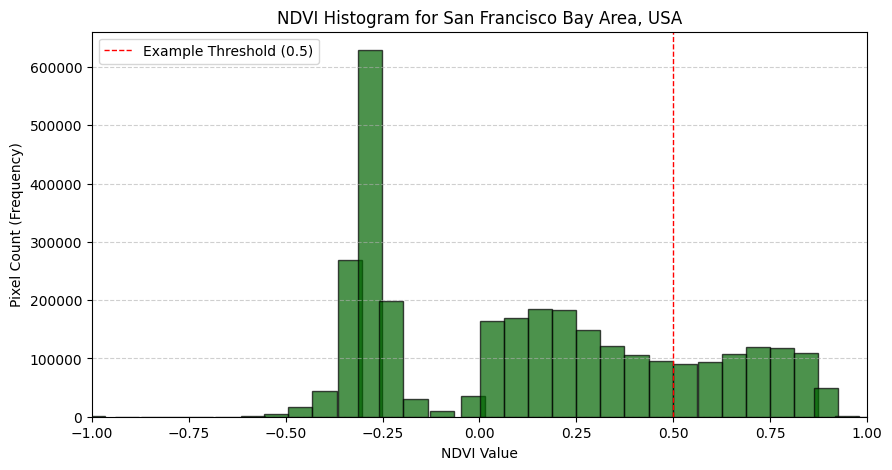

In [6]:
# Cell 9: Analyze NDVI Distribution with a Histogram (Revised)

import matplotlib.pyplot as plt
import numpy as np # For handling potential errors more gracefully

print("\n--- Generating NDVI Histogram ---")

scale = 10

# Ensure the NDVI image exists from the previous step
if 'ndvi' in locals() and ndvi is not None:
    try:
        print(f"Calculating histogram for NDVI over ROI (Scale: {scale}m)...")
        # Calculate histogram using reduceRegion
        ndvi_histogram_dict = ndvi.reduceRegion(
            reducer=ee.Reducer.histogram(maxBuckets=50), # Calculate histogram server-side
            geometry=roi, # Use the defined Region of Interest
            scale=scale, # Use appropriate scale (e.g., 10m or 30m for S2/Landsat)
            maxPixels=1e9, # Limit pixels processed if needed
            bestEffort=True # Use bestEffort for potentially large ROIs
        ).getInfo() # Fetch the result client-side

        # Extract histogram data - **Use the correct band name key ('NDVI')**
        if 'NDVI' in ndvi_histogram_dict and ndvi_histogram_dict['NDVI'] is not None:
            hist_info = ndvi_histogram_dict['NDVI']

            # Extract bucket means (x-axis) and histogram counts (y-axis)
            # Handle potential empty histogram results
            bucket_means = hist_info.get('bucketMeans', [])
            histogram_counts = hist_info.get('histogram', [])
            bucket_width = hist_info.get('bucketWidth', 0.04) # Get width for plotting

            if not bucket_means or not histogram_counts:
                 print("Warning: Histogram calculation returned empty data.")
            else:
                # Plot the histogram using Matplotlib
                print("Plotting histogram...")
                plt.figure(figsize=(10, 5)) # Adjusted figure size slightly
                plt.bar(bucket_means, histogram_counts, width=bucket_width, color='darkgreen', edgecolor='black', alpha=0.7)
                plt.title(f'NDVI Histogram for {location_name}')
                plt.xlabel('NDVI Value')
                plt.ylabel('Pixel Count (Frequency)')
                plt.grid(axis='y', linestyle='--', alpha=0.6)
                plt.xlim(-1, 1) # Ensure x-axis covers the full potential NDVI range
                # Add a vertical line at a potential threshold for illustration
                plt.axvline(0.5, color='red', linestyle='dashed', linewidth=1, label='Example Threshold (0.5)')
                plt.legend()
                plt.show()

        else:
            print("ERROR: Could not find 'NDVI' key or histogram data in the reduction result.")
            print("Reduction Result:", ndvi_histogram_dict) # Print dict to help debug

    except Exception as e:
        print(f"ERROR generating or plotting NDVI histogram: {e}")
else:
    print("Skipping histogram generation because NDVI image is not available.")

## NDVI Threshold
NDVI provides continuous values, but we often want to classify areas into categories.

For example, we can define a threshold (e.g., NDVI > 0.5) to identify pixels that likely represent healthy vegetation.
Apply threshold to classify vegetation (1 = vegetation, 0 = non-vegetation)

In [7]:
print("\n--- Thresholding NDVI ---")
ndvi_threshold = 0.5
print(f"Applying threshold: NDVI > {ndvi_threshold}")
vegetation_mask = None # Initialize to None

try:
    # Directly try to use the 'ndvi' variable from the previous cell
    # If 'ndvi' is None or wasn't defined, this block will likely raise an error
    vegetation_mask = ndvi.gt(ndvi_threshold).rename('vegetation_mask')
    vegetation_mask_viz = vegetation_mask.selfMask()
    print("Vegetation mask created.")

    mask_vis = {'palette': ['00FF00'], 'min': 1, 'max': 1}
    print("Mask visualization parameters defined.")

    map_view = add_ee_layer(map_view, vegetation_mask_viz, mask_vis, f'Vegetation Mask (NDVI > {ndvi_threshold})')
    map_view.add_child(folium.LayerControl())
    display(map_view)

except Exception as e:
    # Catches errors if 'ndvi' doesn't exist (NameError)
    # or if 'ndvi' is None (AttributeError on .gt())
    # or any GEE errors during calculation/layer addition
    print(f"Skipping NDVI thresholding because the 'ndvi' image is invalid or an error occurred: {e}")
    # vegetation_mask remains None


--- Thresholding NDVI ---
Applying threshold: NDVI > 0.5
Vegetation mask created.
Mask visualization parameters defined.
Layer 'Vegetation Mask (NDVI > 0.5)' added successfully.


### NDVI Statistics

After thresholding the NDVI image to identify vegetated areas, we can go one step further by **quantifying and analyzing** the results:

#### Pixel Statistics

- We calculate the **number of pixels** that exceed a threshold (e.g., NDVI > 0.5), which gives us an estimate of **vegetated area**.
- By also counting the **total number of valid pixels** in the region, we can compute the **percentage of vegetated land**.
- This is especially useful in land use planning, environmental monitoring, and drought assessment.

> For example: if 1,200 out of 2,000 pixels are vegetated, then 60% of the area is covered by vegetation.


In [21]:
print("\n--- Calculating Vegetation Statistics within ROI ---")

# Ensure the vegetation mask and ROI exist from previous steps
# Note: ROI was defined in Cell 2; vegetation_mask in Cell 10
if  vegetation_mask is not None:

    try:
        # Define scale for reduction (use native resolution if possible, e.g., 10m for S2)
        stats_scale = 10 # Meters

        # 1. Count number of vegetated pixels (where mask == 1)
        # Use .sum() because vegetated pixels have value 1, non-vegetated 0.
        print(f"Calculating sum of vegetated pixels (Scale: {stats_scale}m)...")
        vegetated_count_dict = vegetation_mask.reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=roi,
            scale=stats_scale,
            maxPixels=1e9, # Increase if needed, but ROI is limited
            bestEffort=True # Allow coarser scale if needed
        )

        # 2. Count total number of valid (unmasked) pixels in the region
        # Apply the mask of the original NDVI or vegetation mask to count only valid pixels
        print(f"Calculating total valid pixel count (Scale: {stats_scale}m)...")
        total_count_dict = vegetation_mask.mask().reduceRegion( # Use mask() to get only valid pixels
            reducer=ee.Reducer.count(), # Count the number of valid pixels
            geometry=roi,
            scale=stats_scale,
            maxPixels=1e9,
            bestEffort=True
        )

        # 3. Retrieve results using getInfo()
        print("Retrieving statistics...")
        veg_pixels_info = vegetated_count_dict.getInfo()
        total_pixels_info = total_count_dict.getInfo()

        # 4. Extract values - **Use the correct band name key ('vegetation_mask')**
        # Check if the keys exist and values are not None
        if ('vegetation_mask' in veg_pixels_info and veg_pixels_info['vegetation_mask'] is not None and
            'vegetation_mask' in total_pixels_info and total_pixels_info['vegetation_mask'] is not None):

            veg_pixels = veg_pixels_info['vegetation_mask']
            total_pixels = total_pixels_info['vegetation_mask']

            # Avoid division by zero if ROI has no valid pixels
            if total_pixels > 0:
                percent_vegetated = (veg_pixels / total_pixels) * 100
                print("\n--- Vegetation Statistics ---")
                print(f"ROI Area: Approximately {((buffer_radius_meters**2) * 3.14159 / 1e6):.2f} sq km")
                print(f"Number of Vegetated Pixels (NDVI > {ndvi_threshold}): {veg_pixels:,.0f}")
                print(f"Total Number of Valid Pixels in ROI: {total_pixels:,.0f}")
                print(f"Percentage Vegetated: {percent_vegetated:.2f}%")
                print("---------------------------")
            else:
                print("Warning: ROI contains no valid pixels for calculation.")

        else:
            print("ERROR: Could not extract statistics values from reduction results.")
            print("Vegetated Count Result:", veg_pixels_info)
            print("Total Count Result:", total_pixels_info)

    except Exception as e:
        print(f"ERROR calculating statistics: {e}")
else:
    print("Skipping statistics calculation because vegetation mask or ROI is not available.")


--- Calculating Vegetation Statistics within ROI ---
Calculating sum of vegetated pixels (Scale: 10m)...
Calculating total valid pixel count (Scale: 10m)...
Retrieving statistics...

--- Vegetation Statistics ---
ROI Area: Approximately 314.16 sq km
Number of Vegetated Pixels (NDVI > 0.5): 688,668
Total Number of Valid Pixels in ROI: 3,103,414
Percentage Vegetated: 22.19%
---------------------------


## 🧪 Exercise: Clay Minerals Ratio (CMR)
The Clay Minerals Ratio (CMR) is a geological index used to detect clay-rich soils and altered rock formations. It's especially useful in mining exploration, as clay minerals like alunite, kaolinite, or illite often indicate hydrothermal alteration zones — areas that may be associated with mineral deposits.

Formula:

$$
\text{CMR}=\frac{\text{SWIR1}}{\text{SWIR2}}
$$

Where:

SWIR1 is typically centered around 1.6 µm (Sentinel-2 band B11)

SWIR2 is typically centered around 2.2 µm (Sentinel-2 band B12)

High values of CMR may indicate the presence of clay, while low values suggest other surface materials (e.g., sand, rock, water).

## Exercise: Iron Oxide Ratio (IOR)

The Iron Oxide Ratio highlights areas with high concentrations of iron oxides (e.g., hematite, goethite, etc.). These can appear in weathered or altered rocks, making IOR useful in volcanic terrains, abandoned mines, or areas with oxidized ore bodies.

Formula:

$$
\text{IOR}=\frac{RED}{BLUE}
$$


Where:

Red band = Sentinel-2 B4 (~0.65 µm)

Blue band = Sentinel-2 B2 (~0.49 µm)

High IOR values suggest strong iron oxide presence (high red reflectance, low blue reflectance).

In [8]:
# Cell 14: Setup for Geology Indices (CMR & IOR) - Simpler Version

print("\n--- Setting up for Geology Indices (CMR/IOR) ---")

# --- Define Locations of Geological Interest ---
geology_locations = {
    'guanajuato': {'name': "Guanajuato", 'coords': [21.0182, -101.2574]}, # lat, lon
    'durango':    {'name': "Durango",    'coords': [25.0566, -104.5032]},
    'zacatecas':  {'name': "Zacatecas",  'coords': [24.7300, -101.5500]},
    'sonora':     {'name': "Sonora",     'coords': [30.9890, -110.3000]},
    'oaxaca':     {'name': "Oaxaca",     'coords': [16.9650, -96.4235]},
    'baja':       {'name': "Baja",       'coords': [27.3360, -112.2700]}
}

# --- Select Location & Date ---
selected_geo_key = 'oaxaca' # CHANGE KEY TO SWITCH LOCATION
geo_start_date = '2022-01-01'
geo_end_date   = '2022-04-30'
s2_collection_id = 'COPERNICUS/S2_SR_HARMONIZED'
geo_max_cloud_percentage = 10
# -----------------------------

# --- Get Location Info ---
selected_geo_info = geology_locations[selected_geo_key]
geo_location_name = selected_geo_info['name']
geo_location_center = selected_geo_info['coords'] # [lat, lon] for Folium Map center
geo_point = ee.Geometry.Point(geo_location_center[::-1]) # [lon, lat] for GEE Point

print(f"Location set to: {geo_location_name}")
print(f"Using date range: {geo_start_date} to {geo_end_date}")

# --- Load and Process Image ---
print("Loading and processing Sentinel-2 image...")
geo_image = ee.ImageCollection(s2_collection_id) \
    .filterBounds(geo_point) \
    .filterDate(geo_start_date, geo_end_date) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', geo_max_cloud_percentage)) \
    .map(apply_s2_sr_scale) \
    .first() # Get the first clear image

# --- Verify Image and Get Date ---
geo_image_date_str = "N/A"
try:
    geo_image_date_str = ee.Date(geo_image.get('system:time_start')).format('YYYY-MM-dd').getInfo()
    print(f"Image acquired on: {geo_image_date_str}")
except Exception as e:
    print(f"ERROR: Could not load image or get date: {e}. Subsequent steps might fail.")
    geo_image = None # Set to None if failed

# --- Create a NEW Folium Map for Geology ---
zoom_level = 12 # Zoom in a bit more for geology potentially
map_geology = folium.Map(location=geo_location_center, zoom_start=zoom_level)
print(f"Created new Folium map centered on {geo_location_name}.")

# --- Add Base Image Layer ---
vis_params_rgb = {'bands': ['B4', 'B3', 'B2'], 'min': 0.0, 'max': 0.3, 'gamma': 1.4}
if geo_image is not None:
    map_geology = add_ee_layer(map_geology, geo_image, vis_params_rgb, f'S2 SR Base ({geo_image_date_str})')
else:
    print("Skipping base layer addition.")

print("\n--- Setup for Geology Indices Complete ---")
# Display map now or after adding CMR/IOR layers
# display(map_geology)


--- Setting up for Geology Indices (CMR/IOR) ---
Location set to: Oaxaca
Using date range: 2022-01-01 to 2022-04-30
Loading and processing Sentinel-2 image...
Image acquired on: 2022-01-03
Created new Folium map centered on Oaxaca.
Layer 'S2 SR Base (2022-01-03)' added successfully.

--- Setup for Geology Indices Complete ---


### Your code goes here

In [11]:
try:
    # --- Clay Minerals Ratio (CMR) ---
    # CMR = SWIR1 / SWIR2 = B11 / B12
    print("Calculating CMR (B11 / B12)...")
    swir1 = geo_image.select('B11')
    swir2 = geo_image.select('B12')
    # Use divide() for safe division (handles potential zeros in denominator if needed, though less likely for reflectance)
    cmr = swir1.divide(swir2).rename('CMR')

    # --- Iron Oxide Ratio (IOR) ---
    # IOR = Red / Blue = B4 / B2
    print("Calculating IOR (B4 / B2)...")
    red = geo_image.select('B4')
    blue = geo_image.select('B2')
    ior = red.divide(blue).rename('IOR')

    print("CMR and IOR calculated successfully.")

except Exception as e:
    print(f"ERROR calculating geology indices: {e}")
    # Ensure cmr and ior remain None if an error occurs

Calculating CMR (B11 / B12)...
Calculating IOR (B4 / B2)...
CMR and IOR calculated successfully.


### Visualization

In [12]:
# Cell 16: Visualize Geology Indices (CMR & IOR) (Revised for Folium - Simplified Checks)

print("\n--- Visualizing Geology Indices ---")

# Assume 'cmr', 'ior' were calculated in the previous cell (or are None if failed)

# --- Define Visualization Parameters ---

# CMR Visualization
cmr_vis = {
    'min': 0.8,
    'max': 1.6,
    'palette': ['#A0522D', '#D2B48C', '#F5F5DC', '#FFFFFF'] # Brown -> Tan -> Beige -> White
}
print("CMR visualization parameters defined.")

# IOR Visualization
ior_vis = {
    'min': 1.0,
    'max': 2.5,
    'palette': ['#000000', '#FFA500', '#FFFF00', '#FFFFFF'] # Black -> Orange -> Yellow -> White
}
print("IOR visualization parameters defined.")


# --- Add Layers to the Geology Map ---
# Directly attempt to add layers. The add_ee_layer function will handle None inputs.
print("Adding CMR layer to map...")
map_geology = add_ee_layer(map_geology, cmr, cmr_vis, 'Clay Minerals Ratio (CMR)')

print("Adding IOR layer to map...")
map_geology = add_ee_layer(map_geology, ior, ior_vis, 'Iron Oxide Ratio (IOR)')


# --- Add Layer Control and Display Final Geology Map ---
map_geology.add_child(folium.LayerControl())
print("Added Layer Control to geology map.")

print("Displaying geology map...")
display(map_geology)

print("\n--- Geology Indices Section Complete ---")


--- Visualizing Geology Indices ---
CMR visualization parameters defined.
IOR visualization parameters defined.
Adding CMR layer to map...
Layer 'Clay Minerals Ratio (CMR)' added successfully.
Adding IOR layer to map...
Layer 'Iron Oxide Ratio (IOR)' added successfully.
Added Layer Control to geology map.
Displaying geology map...



--- Geology Indices Section Complete ---
